**ML challenge Hackrush 23**

In [212]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
device = "cuda"  if torch.cuda.is_available() else "cpu"
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


Input Data  :  (280,6750,32)  size tensor  with each datapoint dimension  (6750*32). Coverted this 6750 rows in each datapoint to 750 rows. Each row as the average of consecutive 9 rows

## Loading the preprocessed data

In [ ]:
def create_data_pt(random_tensor: torch.Tensor)->torch.Tensor:

    le =  int(random_tensor.shape[0]/32)

    arr = torch.zeros(le,random_tensor.shape[1]-1,32,requires_grad = True).to(device)
    for i in range(le):

        data_pt = random_tensor[32*i: 32*(i+1),:-1]
        data_pt = data_pt.T
#         print(data_pt.shape)
        arr[i] =  data_pt


    return arr

In [ ]:
def find_labels(random_tensor:torch.Tensor)-> torch.Tensor:


    y_values = random_tensor[:,-1]

    labels = torch.zeros(int(y_values.shape[0]/32),dtype= int)

    for i in range(len(y_values)):
        if(i%32==0):
    #         print(i)
            ind = int(i/32)
            labels[ind] = y_values[i]



    return labels.to(device)

In [213]:
X_train = np.load("/content/X_train_up.npy")
X_test = np.load("/content/X_test_up (1).npy")

Scaling the data points between -1 and 1


In [214]:
from sklearn.preprocessing import StandardScaler

X_train_tr = []
scaler = StandardScaler()
for i in range(len(X_train)):

    tt  =  scaler.fit_transform(X_train[i])
    X_train_tr.append(tt)
X_train = np.array(X_train_tr)

In [161]:
# from sklearn.decomposition import PCA

# pca = PCA(n_components =16)

# X_train_tr = []

# for i in range(len(X_train)):

#     tt  =  pca.fit_transform(X_train[i])
#     X_train_tr.append(tt)
# X_train = np.array(X_train_tr)

In [215]:
X_test_tr = []

for i in range(len(X_test)):

    tt  =  scaler.fit_transform(X_test[i])
    X_test_tr.append(tt)
X_test = np.array(X_test_tr)

In [216]:
X_train =  torch.tensor(X_train,requires_grad= True).to(device)
X_test =  torch.tensor(X_test,requires_grad = True).to(device)

Shape of preprocessed input

In [217]:
X_train.shape

torch.Size([224, 750, 32])

In [218]:
y_train  = torch.load("/content/y_train.pt",map_location = device)
y_test = torch.load("/content/y_test.pt",map_location = device)


In [219]:
for i in range(len(y_train)):
    y_train[i]-=1;
for i in range(len(y_test)):
    y_test[i]-=1;


Creating batch instance of test and train data

In [220]:
batch_size=10
train_loader = DataLoader(TensorDataset(X_train,y_train), batch_size=10, shuffle=True)
test_loader = DataLoader(TensorDataset(X_test,y_test), batch_size=10,shuffle = True)


In [237]:
l1 = nn.Conv2d(in_channels=1, out_channels=10, kernel_size=4, stride=1, padding=0).to(device)


l2 = nn.Conv2d(in_channels=10, out_channels=100, kernel_size=4, stride=1, padding=0).to(device)
l3 = nn.Conv2d(in_channels=100, out_channels=150, kernel_size=4, stride=1, padding=0,dtype = torch.float32)
pool = nn.MaxPool2d(kernel_size=(2, 2), stride=2).to(device)
print(X_train[0].shape)
a  =l1(X_train[0].unsqueeze(0))
print(a.shape)
print(pool(l3(pool(l2(pool(a))))).shape)

torch.Size([750, 32])
torch.Size([10, 747, 29])
torch.Size([150, 91, 1])


CNN model defintion

In [238]:
class CNNmodel(nn.Module):

    def __init__(self,num_classes):
        super(CNNmodel, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=10, kernel_size=4, stride=1, padding=0,dtype = torch.float32)
        self.conv2 = nn.Conv2d(in_channels=10, out_channels=100, kernel_size=4, stride=1, padding=0,dtype = torch.float32)
        self.conv3 = nn.Conv2d(in_channels=100, out_channels=150, kernel_size=4, stride=1, padding=0,dtype = torch.float32)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(150*91*1, 128,dtype = torch.float32)
        self.fc3 = nn.Linear(40, num_classes,dtype = torch.float32)  # Adjust input size based on your data dimensions
        self.fc2 = nn.Linear(128, 40,dtype = torch.float32)

    def forward(self,x):

        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 150*91*1)  # Adjust input size based on your data dimensions

        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x= F.relu(x)
        x = self.fc3(x)
        return x



In [239]:
model = CNNmodel(9).to(device)
# model
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [240]:
test  =[]
train =[]

In [241]:
def test_acc(model,test_loader =  test_loader):
  test_acc = 0
  with torch.inference_mode():
      for sequences,label in test_loader:
          sequences = sequences.to(device)
          label = label.to(device)
          preds = model(sequences.unsqueeze(1))

          preds =  torch.argmax(preds,axis =1)

          test_acc += (preds==label.squeeze()).sum()
  return test_acc/len(y_test)
# print(f"accuracy on testing set {test_acc/len(y_test)}")

In [242]:
def train_acc(model,train_loader= train_loader):
  train_acc = 0
  with torch.inference_mode():
      for sequences,label in train_loader:
          sequences = sequences.to(device)
          label = label.to(device)
          preds = model(sequences.unsqueeze(1))

          preds =  torch.argmax(preds,axis =1)

          train_acc += (preds==label.squeeze()).sum()
  return train_acc/len(y_test)
  # print(f"accuracy on training set {train_acc/len(y_train)}")


In [243]:
num_epochs = 15
for epoch in range(num_epochs):


    for batch_idx, (data, targets) in enumerate(train_loader):
        model.train()
        optimizer.zero_grad()
        data = data.to(device=device, dtype=torch.float32)
        outputs = model(data.unsqueeze(1))
        outputs = outputs.to(device =  device, dtype = torch.float32)
#         targets = targets.to(device=device, dtype=torch.float32)# Add a channel dimension
        # print(data.shape,targets.shape)
        loss = criterion(outputs, targets.squeeze())
        loss.backward()
        optimizer.step()
        if (batch_idx + 1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{batch_idx+1}/{len(train_loader)}], Loss: {loss.item():.4f}')
            train.append(train_acc(model,train_loader).item())
            test.append(test_acc(model,test_loader).item())

# Evaluation


Epoch [1/15], Step [10/23], Loss: 2.1558
Epoch [1/15], Step [20/23], Loss: 2.2091
Epoch [2/15], Step [10/23], Loss: 2.2325
Epoch [2/15], Step [20/23], Loss: 2.1987
Epoch [3/15], Step [10/23], Loss: 2.2006
Epoch [3/15], Step [20/23], Loss: 2.1837
Epoch [4/15], Step [10/23], Loss: 2.2285
Epoch [4/15], Step [20/23], Loss: 2.2808
Epoch [5/15], Step [10/23], Loss: 1.6522
Epoch [5/15], Step [20/23], Loss: 2.1045
Epoch [6/15], Step [10/23], Loss: 1.0881
Epoch [6/15], Step [20/23], Loss: 1.5905
Epoch [7/15], Step [10/23], Loss: 1.4287
Epoch [7/15], Step [20/23], Loss: 1.6612
Epoch [8/15], Step [10/23], Loss: 0.7179
Epoch [8/15], Step [20/23], Loss: 0.8368
Epoch [9/15], Step [10/23], Loss: 0.6490
Epoch [9/15], Step [20/23], Loss: 0.1751
Epoch [10/15], Step [10/23], Loss: 0.1479
Epoch [10/15], Step [20/23], Loss: 0.3928
Epoch [11/15], Step [10/23], Loss: 0.0768
Epoch [11/15], Step [20/23], Loss: 0.2218
Epoch [12/15], Step [10/23], Loss: 0.0588
Epoch [12/15], Step [20/23], Loss: 0.0297
Epoch [13/

In [246]:
train

[0.4285714328289032,
 0.4285714328289032,
 0.4285714328289032,
 0.4285714328289032,
 0.5357142686843872,
 0.7321428656578064,
 0.75,
 1.0535714626312256,
 1.625,
 1.5178571939468384,
 1.75,
 1.5535714626312256,
 2.4107143878936768,
 2.642857074737549,
 2.857142925262451,
 3.3392856121063232,
 3.4642856121063232,
 3.5357143878936768,
 3.5357143878936768,
 3.892857074737549,
 3.9464285373687744,
 3.9642856121063232,
 3.9642856121063232,
 3.8035714626312256,
 3.875,
 4.0,
 4.0,
 4.0,
 4.0,
 4.0]

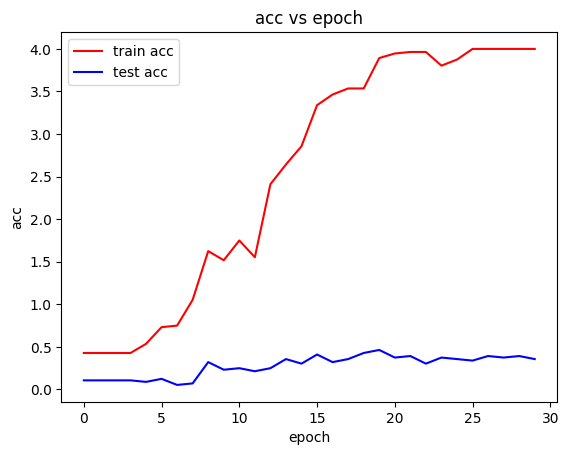

In [250]:
plt.plot(range(len(train)), train, color = 'r', label = "train acc")
plt.plot(range(len(test)), test, color = 'b',label = "test acc")
plt.title("acc vs epoch")
plt.xlabel("epoch")
plt.ylabel("acc")
plt.legend()
plt.show()

In [253]:
torch.save(model.state_dict(),"model_13_cnn.pth")

In [254]:
test_point = torch.load("/content/og_test_points.pt")

In [207]:
# import pandas as pd
# test = pd.read_excel("/content/Test.xlsx")

# test = test.drop(columns= ["ID"])
# test = test.values

# print(test.shape)
# test = torch.tensor(test,dtype = torch.float32)
# def create_data_pt(random_tensor: torch.Tensor)->torch.Tensor:

#     le =  int(random_tensor.shape[0]/32)

#     arr = torch.zeros(le,random_tensor.shape[1],32).to(device)
#     for i in range(le):

#         data_pt = random_tensor[32*i: 32*(i+1),:]
#         data_pt = data_pt.T
# #         print(data_pt.shape)
#         arr[i] =  data_pt


#     return arr

# test_points=  create_data_pt(test)

# print(test_points.shape)

Exception ignored in: <function _xla_gc_callback at 0x786c8acd6320>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/jax/_src/lib/__init__.py", line 98, in _xla_gc_callback
    def _xla_gc_callback(*args):
KeyboardInterrupt: 


KeyboardInterrupt: 

In [ ]:
torch.save(test_points,"og_test_points.pt")

In [255]:

preds = model(test_points.unsqueeze(1))
preds  = torch.argmax(preds ,axis=1)
preds = preds.numpy()



dictt = {0: 'Tiger',
    1: 'Snake',
    2: 'Wolf',
    3: 'Bear',
    4: 'Rabbit',
    5: 'Monkey',
    6: 'Eagle',
    7: 'Dolphin',
    8: 'Koala'}

arr1  = [ dictt[i]  for i in preds]
arr1

['Rabbit',
 'Dolphin',
 'Rabbit',
 'Rabbit',
 'Dolphin',
 'Bear',
 'Rabbit',
 'Rabbit',
 'Bear',
 'Bear',
 'Tiger',
 'Eagle',
 'Rabbit',
 'Rabbit',
 'Monkey',
 'Eagle',
 'Snake',
 'Rabbit',
 'Dolphin',
 'Dolphin',
 'Rabbit',
 'Koala',
 'Eagle',
 'Snake',
 'Bear',
 'Snake',
 'Dolphin',
 'Snake',
 'Tiger',
 'Bear',
 'Rabbit',
 'Rabbit',
 'Eagle',
 'Rabbit',
 'Dolphin',
 'Rabbit',
 'Rabbit',
 'Bear',
 'Bear',
 'Eagle',
 'Dolphin',
 'Bear',
 'Monkey',
 'Tiger',
 'Dolphin',
 'Rabbit',
 'Monkey',
 'Wolf',
 'Bear',
 'Tiger',
 'Snake',
 'Rabbit',
 'Koala',
 'Dolphin',
 'Eagle',
 'Rabbit',
 'Bear',
 'Koala',
 'Bear',
 'Snake',
 'Bear',
 'Bear',
 'Tiger',
 'Rabbit',
 'Koala',
 'Bear',
 'Bear',
 'Rabbit',
 'Rabbit',
 'Tiger',
 'Snake',
 'Monkey',
 'Tiger',
 'Koala',
 'Eagle',
 'Tiger',
 'Koala',
 'Tiger',
 'Koala',
 'Tiger',
 'Koala',
 'Koala',
 'Koala',
 'Eagle',
 'Rabbit',
 'Dolphin',
 'Eagle',
 'Tiger',
 'Eagle',
 'Monkey',
 'Rabbit',
 'Tiger',
 'Monkey',
 'Dolphin',
 'Rabbit',
 'Snake',
 'Rab

Submission Labels

In [256]:
test_point.shape

torch.Size([271, 750, 32])